In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")



# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import pickle
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations


from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder #, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../src"))   
import Soporte_encoding as f
import Soporte_preprocesamiento as b

from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [2]:
df_sinull=pd.read_pickle("../../datos/datos3/datos_sin_nulos.pkl").reset_index(drop=True)


In [3]:
df_sinull.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement
0,51.00,0.00,Travel_Rarely,Sales,entre 5 y 8,College,Life Sciences,Female,Intern,Healthcare Representative,Married,"1,482.11",1,11.00,Bad,1,6.00,1.00,0.00,High,Very High,Good,High
1,31.00,1.00,Travel_Frequently,Research & Development,entre 9 y 12,Below College,Life Sciences,Female,Intern,Research Scientist,Single,473.36,0,23.00,Good,6,3.00,5.00,1.00,High,Medium,Best,Medium
2,32.00,0.00,Travel_Frequently,Research & Development,entre 13 y 18,Master,Other,Male,Manager,Sales Executive,Married,"2,184.06",1,15.00,Best,5,2.00,5.00,0.00,Medium,Medium,Bad,High
3,38.00,0.00,Non-Travel,Research & Development,entre 1 y 4,Doctor,Life Sciences,Male,Senior,Human Resources,Married,940.27,3,11.00,Best,13,5.00,8.00,7.00,Very High,Very High,Better,Medium
4,32.00,0.00,Travel_Rarely,Research & Development,entre 9 y 12,Below College,Medical,Male,Intern,Sales Executive,Single,264.65,4,12.00,Better,9,2.00,6.00,0.00,Very High,Low,Better,High


In [4]:
df_sinull_copy=df_sinull.copy()

In [5]:
df_sinull_copy["TotalWorkingYears"]=df_sinull_copy["TotalWorkingYears"].astype("category")
df_sinull_copy["NumCompaniesWorked"]=df_sinull_copy["NumCompaniesWorked"].astype("category")

In [6]:
df_categoricas= df_sinull_copy.select_dtypes(include=["category","object"])

In [7]:
df_categoricas.head()

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,NumCompaniesWorked,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement
0,Travel_Rarely,Sales,entre 5 y 8,College,Life Sciences,Female,Intern,Healthcare Representative,Married,1,Bad,1,6.00,High,Very High,Good,High
1,Travel_Frequently,Research & Development,entre 9 y 12,Below College,Life Sciences,Female,Intern,Research Scientist,Single,0,Good,6,3.00,High,Medium,Best,Medium
2,Travel_Frequently,Research & Development,entre 13 y 18,Master,Other,Male,Manager,Sales Executive,Married,1,Best,5,2.00,Medium,Medium,Bad,High
3,Non-Travel,Research & Development,entre 1 y 4,Doctor,Life Sciences,Male,Senior,Human Resources,Married,3,Best,13,5.00,Very High,Very High,Better,Medium
4,Travel_Rarely,Research & Development,entre 9 y 12,Below College,Medical,Male,Intern,Sales Executive,Single,4,Better,9,2.00,Very High,Low,Better,High


Tenemos 17 columnas de categóricas

In [8]:
df_categoricas.nunique()

BusinessTravel              3
Department                  3
DistanceFromHome            6
Education                   5
EducationField              6
Gender                      2
JobLevel                    5
JobRole                     9
MaritalStatus               3
NumCompaniesWorked         10
StockOptionLevel            4
TotalWorkingYears          40
TrainingTimesLastYear       7
EnvironmentSatisfaction     4
JobSatisfaction             4
WorkLifeBalance             4
JobInvolvement              4
dtype: int64

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

Tuve que convertir estas variables a str porque sino no las detectaba como categóricas

In [9]:
# df_sinout_copy["exterior"]=df_sinout_copy["exterior"].astype(str)
# df_sinout_copy["rooms"]=df_sinout_copy["rooms"].astype(str)
# df_sinout_copy["bathrooms"]=df_sinout_copy["bathrooms"].astype(str)

In [10]:
f.detectar_orden_cat(df_sinull_copy,df_categoricas.columns,"Attrition")

Estamos evaluando el orden de la variable BUSINESSTRAVEL


Attrition,0.00,1.00
BusinessTravel,,
Non-Travel,147,12
Travel_Frequently,220,77
Travel_Rarely,954,163


La variable BusinessTravel SI tiene orden
Estamos evaluando el orden de la variable DEPARTMENT


Attrition,0.00,1.00
Department,,
Human Resources,44,22
Research & Development,870,160
Sales,407,70


La variable Department SI tiene orden
Estamos evaluando el orden de la variable DISTANCEFROMHOME


Attrition,0.00,1.00
DistanceFromHome,,
entre 1 y 4,515,99
entre 13 y 18,122,29
entre 19 y 23,103,18
entre 24 y 29,132,18
entre 5 y 8,265,45
entre 9 y 12,184,43


La variable DistanceFromHome NO tiene orden
Estamos evaluando el orden de la variable EDUCATION


Attrition,0.00,1.00
Education,,
Below College,154,27
College,246,57
Bachelor,519,96
Master,358,64
Doctor,44,8


La variable Education NO tiene orden
Estamos evaluando el orden de la variable EDUCATIONFIELD


Attrition,0.00,1.00
EducationField,,
Human Resources,16,12
Life Sciences,547,108
Marketing,141,26
Medical,408,81
Other,80,10
Technical Degree,129,15


La variable EducationField SI tiene orden
Estamos evaluando el orden de la variable GENDER


Attrition,0.00,1.00
Gender,,
Female,525,95
Male,796,157


La variable Gender NO tiene orden
Estamos evaluando el orden de la variable JOBLEVEL


Attrition,0.00,1.00
JobLevel,,
Intern,500,87
Junior,467,104
Senior,197,32
Manager,94,17
Head,63,12


La variable JobLevel NO tiene orden
Estamos evaluando el orden de la variable JOBROLE


Attrition,0.00,1.00
JobRole,,
Healthcare Representative,124,21
Human Resources,47,7
Laboratory Technician,232,46
Manager,91,16
Manufacturing Director,141,16
Research Director,63,22
Research Scientist,254,54
Sales Executive,290,58
Sales Representative,79,12


La variable JobRole NO tiene orden
Estamos evaluando el orden de la variable MARITALSTATUS


Attrition,0.00,1.00
MaritalStatus,,
Divorced,320,37
Married,635,85
Single,366,130


La variable MaritalStatus SI tiene orden
Estamos evaluando el orden de la variable NUMCOMPANIESWORKED


Attrition,0.00,1.00
NumCompaniesWorked,,
0,188,25
1,443,103
2,142,17
3,157,18
4,132,19
5,49,17
6,57,18
7,62,17
8,49,6


La variable NumCompaniesWorked SI tiene orden
Estamos evaluando el orden de la variable STOCKOPTIONLEVEL


Attrition,0.00,1.00
StockOptionLevel,,
Bad,564,112
Good,544,97
Better,138,28
Best,75,15


La variable StockOptionLevel NO tiene orden
Estamos evaluando el orden de la variable TOTALWORKINGYEARS


Attrition,0.00,1.00
TotalWorkingYears,,
0,7,6
1,43,41
2,22,9
3,36,9
4,55,12
5,80,17
6,108,24
7,68,22
8,94,17


La variable TotalWorkingYears SI tiene orden
Estamos evaluando el orden de la variable TRAININGTIMESLASTYEAR


Attrition,0.00,1.00
TrainingTimesLastYear,,
0.00,45,10
1.00,64,11
2.00,486,103
3.00,432,90
4.00,116,17
5.00,112,17
6.00,66,4


La variable TrainingTimesLastYear NO tiene orden
Estamos evaluando el orden de la variable ENVIRONMENTSATISFACTION


Attrition,0.00,1.00
EnvironmentSatisfaction,,
High,429,68
Low,226,74
Medium,262,48
Very High,404,62


La variable EnvironmentSatisfaction SI tiene orden
Estamos evaluando el orden de la variable JOBSATISFACTION


Attrition,0.00,1.00
JobSatisfaction,,
High,398,78
Low,232,69
Medium,255,50
Very High,436,55


La variable JobSatisfaction SI tiene orden
Estamos evaluando el orden de la variable WORKLIFEBALANCE


Attrition,0.00,1.00
WorkLifeBalance,,
Bad,56,27
Best,129,28
Better,834,136
Good,302,61


La variable WorkLifeBalance SI tiene orden
Estamos evaluando el orden de la variable JOBINVOLVEMENT


Attrition,0.00,1.00
JobInvolvement,,
Low,71,19
Medium,333,62
High,789,144
Very High,128,27


La variable JobInvolvement NO tiene orden


#### CONCLUSIONES SOBRE EL ORDEN:  

**NO ORDENADAS:**
- Gender  
- DistanceFromHome  
- Education   
- JobLevel  
- StockOptionLevel  
- JobInvolvement a
- TrainingTimesLastYear a 
- JobRole  a
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- BusinessTravel 
- Department  
- MaritalStatus  
- NumCompaniesWorked  
- EnvironmentSatisfaction  
- JobSatisfaction  
- WorkLifeBalance  
- EducationField  
- TotalWorkingYears  
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [11]:
df_sinull_copy.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement'],
      dtype='object')

In [12]:
diccionario_encoding = {"onehot": ["Gender", "DistanceFromHome", "Education", "JobLevel", "StockOptionLevel", "JobRole", "TrainingTimesLastYear", "JobInvolvement"], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["BusinessTravel", "Department", "MaritalStatus","NumCompaniesWorked", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "EducationField", "TotalWorkingYears"]  
                        }

In [13]:
cols_onehot = ["Gender", "DistanceFromHome", "Education", "JobLevel", "StockOptionLevel", "JobRole", "TrainingTimesLastYear", "JobInvolvement"]
one_hot_encoder = OneHotEncoder(categories='auto', 
                        drop=None, 
                        sparse_output=True, 
                        dtype='float', 
                        handle_unknown='error')

encoder_trans = one_hot_encoder.fit_transform(df_sinull_copy[cols_onehot])
encoder_array = encoder_trans.toarray()

# usamos el método get_feature_names_out() para extraer el nombre de las columnas
nombre_columnas = one_hot_encoder.get_feature_names_out()

encoder_df = pd.DataFrame(encoder_array, columns = nombre_columnas)
df_sinull_copy = pd.concat([df_sinull_copy, encoder_df], axis = 1)
df_sinull_copy.drop(columns=cols_onehot, inplace=True)


In [14]:

with open('../../transformers/preprocesamiento3/one_hot_encoder.pkl', 'wb') as o:
    pickle.dump(one_hot_encoder, o)
    


In [15]:
one_hot_encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['entre 1 y 4', 'entre 13 y 18', 'entre 19 y 23', 'entre 24 y 29',
        'entre 5 y 8', 'entre 9 y 12'], dtype=object),
 array(['Bachelor', 'Below College', 'College', 'Doctor', 'Master'],
       dtype=object),
 array(['Head', 'Intern', 'Junior', 'Manager', 'Senior'], dtype=object),
 array(['Bad', 'Best', 'Better', 'Good'], dtype=object),
 array(['Healthcare Representative', 'Human Resources',
        'Laboratory Technician', 'Manager', 'Manufacturing Director',
        'Research Director', 'Research Scientist', 'Sales Executive',
        'Sales Representative'], dtype=object),
 array([0., 1., 2., 3., 4., 5., 6.]),
 array(['High', 'Low', 'Medium', 'Very High'], dtype=object)]

In [16]:
df_sinull_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Age                                1573 non-null   float64 
 1   Attrition                          1573 non-null   float64 
 2   BusinessTravel                     1573 non-null   object  
 3   Department                         1573 non-null   object  
 4   EducationField                     1573 non-null   object  
 5   MaritalStatus                      1573 non-null   object  
 6   MonthlyIncome                      1573 non-null   float64 
 7   NumCompaniesWorked                 1573 non-null   category
 8   PercentSalaryHike                  1573 non-null   float64 
 9   TotalWorkingYears                  1573 non-null   category
 10  YearsAtCompany                     1573 non-null   float64 
 11  YearsSinceLastPromotion            1573 non

In [17]:
target_encoder= TargetEncoder(cols=["BusinessTravel", "Department", "MaritalStatus","NumCompaniesWorked", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "EducationField", "TotalWorkingYears"])
encoded= target_encoder.fit_transform(df_sinull_copy , df_sinull_copy[["Attrition"]])



In [18]:
with open('../../transformers/preprocesamiento3/target_encoder.pkl', 'wb') as t:
    pickle.dump(target_encoder, t)

In [19]:
encoded.head(2)

,Age,Attrition,BusinessTravel,Department,EducationField,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Gender_Female,Gender_Male,DistanceFromHome_entre 1 y 4,DistanceFromHome_entre 13 y 18,DistanceFromHome_entre 19 y 23,DistanceFromHome_entre 24 y 29,DistanceFromHome_entre 5 y 8,DistanceFromHome_entre 9 y 12,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,TrainingTimesLastYear_0.0,TrainingTimesLastYear_1.0,TrainingTimesLastYear_2.0,TrainingTimesLastYear_3.0,TrainingTimesLastYear_4.0,TrainingTimesLastYear_5.0,TrainingTimesLastYear_6.0,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High
0,51.00,0.00,0.15,0.15,0.16,0.12,"1,482.11",0.19,11.00,0.49,1.00,0.00,0.14,0.11,0.17,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
1,31.00,1.00,0.26,0.16,0.16,0.26,473.36,0.12,23.00,0.18,5.00,1.00,0.14,0.16,0.18,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [20]:
encoded.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'EducationField',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Gender_Female', 'Gender_Male',
       'DistanceFromHome_entre 1 y 4', 'DistanceFromHome_entre 13 y 18',
       'DistanceFromHome_entre 19 y 23', 'DistanceFromHome_entre 24 y 29',
       'DistanceFromHome_entre 5 y 8', 'DistanceFromHome_entre 9 y 12',
       'Education_Bachelor', 'Education_Below College', 'Education_College',
       'Education_Doctor', 'Education_Master', 'JobLevel_Head',
       'JobLevel_Intern', 'JobLevel_Junior', 'JobLevel_Manager',
       'JobLevel_Senior', 'StockOptionLevel_Bad', 'StockOptionLevel_Best',
       'StockOptionLevel_Better', 'StockOptionLevel_Good',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laborato

In [21]:
encoded.head()

,Age,Attrition,BusinessTravel,Department,EducationField,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Gender_Female,Gender_Male,DistanceFromHome_entre 1 y 4,DistanceFromHome_entre 13 y 18,DistanceFromHome_entre 19 y 23,DistanceFromHome_entre 24 y 29,DistanceFromHome_entre 5 y 8,DistanceFromHome_entre 9 y 12,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,TrainingTimesLastYear_0.0,TrainingTimesLastYear_1.0,TrainingTimesLastYear_2.0,TrainingTimesLastYear_3.0,TrainingTimesLastYear_4.0,TrainingTimesLastYear_5.0,TrainingTimesLastYear_6.0,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High
0,51.00,0.00,0.15,0.15,0.16,0.12,"1,482.11",0.19,11.00,0.49,1.00,0.00,0.14,0.11,0.17,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
1,31.00,1.00,0.26,0.16,0.16,0.26,473.36,0.12,23.00,0.18,5.00,1.00,0.14,0.16,0.18,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,32.00,0.00,0.26,0.16,0.11,0.12,"2,184.06",0.19,15.00,0.18,5.00,0.00,0.15,0.16,0.32,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,38.00,0.00,0.08,0.16,0.16,0.12,940.27,0.10,11.00,0.09,8.00,7.00,0.13,0.11,0.14,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
4,32.00,0.00,0.15,0.16,0.17,0.26,264.65,0.13,12.00,0.11,6.00,0.00,0.13,0.23,0.14,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


### **DESBALANCEO**  
  
   

In [22]:
round(encoded["Attrition"].value_counts(normalize=True)*100,2)

Attrition
0.00   83.98
1.00   16.02
Name: proportion, dtype: float64

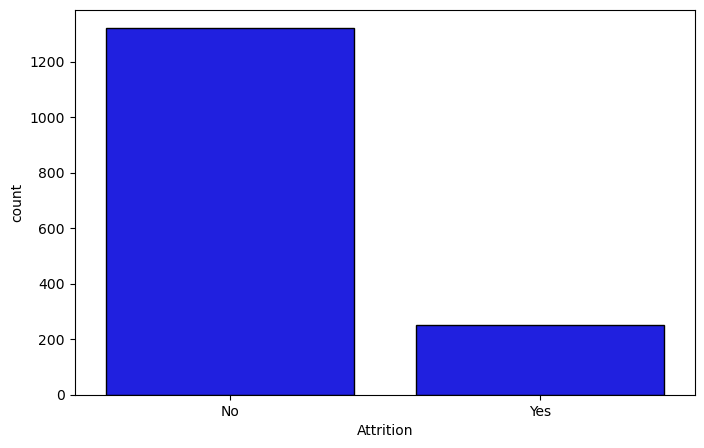

In [23]:
desbalanceo=b.Desbalanceo(encoded,"Attrition")
desbalanceo.visualizar_clase(color="blue", edgecolor="black")

#### **USO UN TOMEKLINK**

-  Elimina pares de muestras cercanas entre la clase mayoritaria y la clase minoritaria donde el vecino más cercano de un punto de la clase minoritaria pertenece a la clase mayoritaria.

In [24]:
encoded.shape

(1573, 57)

In [25]:
balanced_tomek=desbalanceo.balancear_clases_tomek()

In [26]:
balanced_tomek.shape

(1487, 57)

In [42]:
balanced_tomek.head(2)

,Age,BusinessTravel,Department,EducationField,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Gender_Female,Gender_Male,DistanceFromHome_entre 1 y 4,DistanceFromHome_entre 13 y 18,DistanceFromHome_entre 19 y 23,DistanceFromHome_entre 24 y 29,DistanceFromHome_entre 5 y 8,DistanceFromHome_entre 9 y 12,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,TrainingTimesLastYear_0.0,TrainingTimesLastYear_1.0,TrainingTimesLastYear_2.0,TrainingTimesLastYear_3.0,TrainingTimesLastYear_4.0,TrainingTimesLastYear_5.0,TrainingTimesLastYear_6.0,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,Attrition
0,51.00,0.15,0.15,0.16,0.12,"1,482.11",0.19,11.00,0.49,1.00,0.00,0.14,0.11,0.17,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
1,31.00,0.26,0.16,0.16,0.26,473.36,0.12,23.00,0.18,5.00,1.00,0.14,0.16,0.18,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00


In [27]:
round(balanced_tomek["Attrition"].value_counts(normalize=True)*100,2)

Attrition
0.00   83.05
1.00   16.95
Name: proportion, dtype: float64

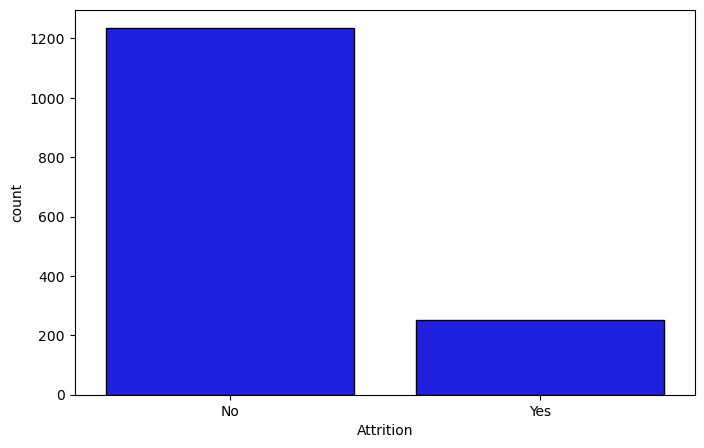

In [28]:
desbalanceo2=b.Desbalanceo(balanced_tomek,"Attrition")
desbalanceo2.visualizar_clase(color="blue", edgecolor="black")

#### **USO UN SMOTENC PARA QUE NO TOQUE LAS CATEGORICAS**

In [29]:
columnas_son_cat_encoded=['Gender_Female', 'Gender_Male',
       'DistanceFromHome_entre 1 y 4', 'DistanceFromHome_entre 13 y 18',
       'DistanceFromHome_entre 19 y 23', 'DistanceFromHome_entre 24 y 29',
       'DistanceFromHome_entre 5 y 8', 'DistanceFromHome_entre 9 y 12',
       'Education_Bachelor', 'Education_Below College', 'Education_College',
       'Education_Doctor', 'Education_Master', 'JobLevel_Head',
       'JobLevel_Intern', 'JobLevel_Junior', 'JobLevel_Manager',
       'JobLevel_Senior', 'StockOptionLevel_Bad', 'StockOptionLevel_Best',
       'StockOptionLevel_Better', 'StockOptionLevel_Good',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'TrainingTimesLastYear_0.0',
       'TrainingTimesLastYear_1.0', 'TrainingTimesLastYear_2.0',
       'TrainingTimesLastYear_3.0', 'TrainingTimesLastYear_4.0',
       'TrainingTimesLastYear_5.0', 'TrainingTimesLastYear_6.0',
       'JobInvolvement_High', 'JobInvolvement_Low', 'JobInvolvement_Medium',
       'JobInvolvement_Very High'
       ,"BusinessTravel", "Department", "MaritalStatus","NumCompaniesWorked", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "EducationField", "TotalWorkingYears"]

In [30]:
balanced_tomek.shape

(1487, 57)

In [31]:
encoded.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'EducationField',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Gender_Female', 'Gender_Male',
       'DistanceFromHome_entre 1 y 4', 'DistanceFromHome_entre 13 y 18',
       'DistanceFromHome_entre 19 y 23', 'DistanceFromHome_entre 24 y 29',
       'DistanceFromHome_entre 5 y 8', 'DistanceFromHome_entre 9 y 12',
       'Education_Bachelor', 'Education_Below College', 'Education_College',
       'Education_Doctor', 'Education_Master', 'JobLevel_Head',
       'JobLevel_Intern', 'JobLevel_Junior', 'JobLevel_Manager',
       'JobLevel_Senior', 'StockOptionLevel_Bad', 'StockOptionLevel_Best',
       'StockOptionLevel_Better', 'StockOptionLevel_Good',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laborato

In [32]:
df_balanceado_smote=desbalanceo2.balancear_clase_smotenc(columnas_son_cat_encoded, sampling_strategy=0.8)

In [33]:
df_balanceado_smote.head(3)

,Age,BusinessTravel,Department,EducationField,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Gender_Female,Gender_Male,DistanceFromHome_entre 1 y 4,DistanceFromHome_entre 13 y 18,DistanceFromHome_entre 19 y 23,DistanceFromHome_entre 24 y 29,DistanceFromHome_entre 5 y 8,DistanceFromHome_entre 9 y 12,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,TrainingTimesLastYear_0.0,TrainingTimesLastYear_1.0,TrainingTimesLastYear_2.0,TrainingTimesLastYear_3.0,TrainingTimesLastYear_4.0,TrainingTimesLastYear_5.0,TrainingTimesLastYear_6.0,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,Attrition
0,51.00,0.15,0.15,0.16,0.12,"1,482.11",0.19,11.00,0.49,1.00,0.00,0.14,0.11,0.17,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
1,31.00,0.26,0.16,0.16,0.26,473.36,0.12,23.00,0.18,5.00,1.00,0.14,0.16,0.18,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
2,32.00,0.26,0.16,0.11,0.12,"2,184.06",0.19,15.00,0.18,5.00,0.00,0.15,0.16,0.32,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [34]:
round(df_balanceado_smote["Attrition"].value_counts(normalize=True)*100,2)

Attrition
0.00   55.56
1.00   44.44
Name: proportion, dtype: float64

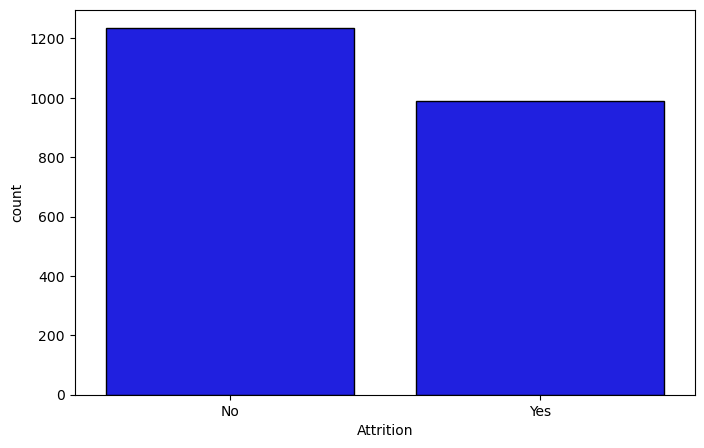

In [35]:
desbalanceo3=b.Desbalanceo(df_balanceado_smote,"Attrition")
desbalanceo3.visualizar_clase(color="blue", edgecolor="black")

revisar que valores unicos de Attrition se hayan mantenido

In [36]:
df_balanceado_smote.shape

(2223, 57)

In [37]:
balanced_tomek2=desbalanceo3.balancear_clases_tomek()

In [38]:
balanced_tomek2.shape

(2181, 57)

In [39]:
round(balanced_tomek2["Attrition"].value_counts(normalize=True)*100,2)

Attrition
0.00   54.70
1.00   45.30
Name: proportion, dtype: float64

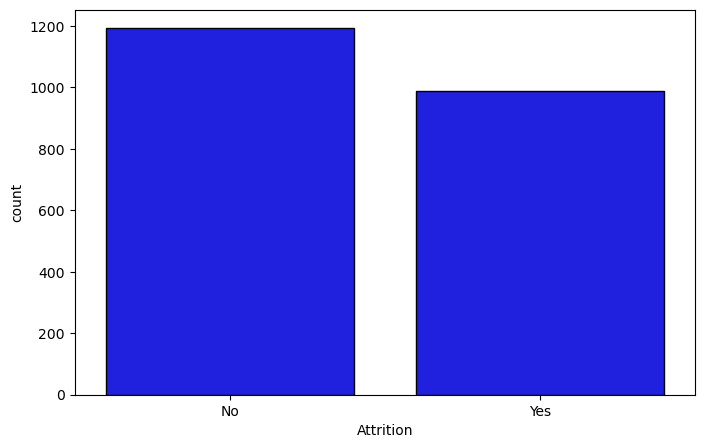

In [40]:
desbalanceo4=b.Desbalanceo(balanced_tomek2,"Attrition")
desbalanceo4.visualizar_clase(color="blue", edgecolor="black")

Uso el primer Tomek para reducir un poco la mayoritaria (No demasiado he de decir) y hacer los "márgenes más claros entre las clases. Luego uso el Smotenc que me hace un upsampling y finalmente uso un tomek de nuevo para volver a marcar bien las clases tras haber generado datos con el smotenc.

In [41]:
balanced_tomek2.to_pickle("../../datos/datos3/datos_sinnull_encoded_balanced.pkl")